# A Gentle Introduction to PyTorch

Kinshuk Vasisht

DS 207 - Introduction to NLP

February 2025

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import gc

import torch
import numpy
import torchviz
import tqdm.auto as tqdm
from matplotlib import pyplot

from lib import draw_examples as _draw_examples

def draw(*args, title='', **kwargs):
    if args: kwargs[''] = args
    examples = [
        { name: _eg for name, _eg in zip(kwargs.keys(), eg) }
        for eg in zip(*list(kwargs.values()))
    ]
    return _draw_examples(title, examples)

### PyTorch

Python-based scientific computing package serving two broad purposes:

- A replacement for NumPy to utilize GPUs and other accelerators.
- An automatic differentiation library that is useful to implement neural networks.

### Installation

- Available install options: https://pytorch.org/get-started/locally/
- `pip` (preferred):
```bash
pip install torch
```

- `conda` (deprecated from v2.5 onwards):
```bash
conda install -c pytorch pytorch
```

- CUDA versions require additional index URLs specific to CUDA toolkit version:
```bash
# assuming cuda-toolkit 12.4 is available
pip install --index-url https://download.pytorch.org/whl/cu124
# or if via conda
conda install -c pytorch -c nvidia pytorch pytorch-cuda=12.4
```

### Quickstart - Tensors

- Creation: `torch.tensor`, `torch.as_tensor`
- Utilities: `torch.rand`, `torch.ones`, `torch.arange`, etc.

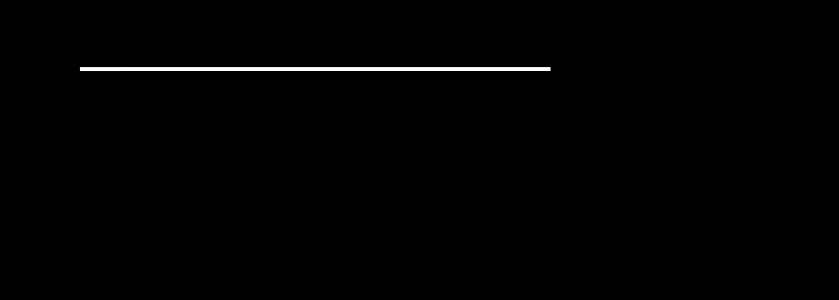

In [4]:
data = torch.tensor([ 1, 2, -9 ])
draw(data, torch.arange(5), torch.zeros((2, 3)))

#### `torch.tensor` vs `torch.as_tensor`

In [5]:
data = torch.as_tensor([ 1, 2, 3 ])
data

tensor([1, 2, 3])

In [9]:
np_data = numpy.eye(3)
pt_data = torch.tensor(np_data)
pt_data[2, 1] = -5
np_data

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

#### Tensor Properties
- Dimensions: `shape` / `size` (`shape` in numpy)

In [10]:
pt_data.shape

torch.Size([3, 3])

- Element datatype: `dtype`

In [11]:
pt_data.dtype

torch.float64

- Device: `device`
  - one of `cpu`, `cuda:{#N}` (GPU), `mps` (Apple Metal), etc.

In [12]:
pt_data.device

device(type='cpu')

### Broadcasting

- Seemingly non-compatible tensors get *broadcasted* for compatible operations.


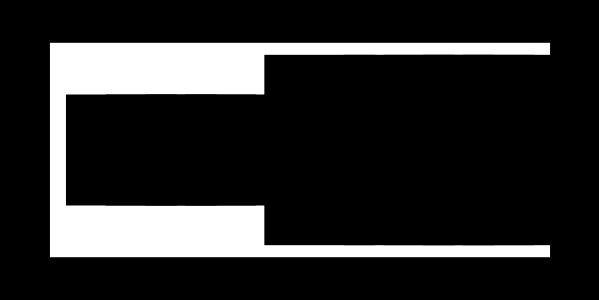

In [13]:
a = torch.arange(4) * -1 # (4,)
b = torch.arange(3)[:, None] # (3, 1)
draw(a, b, a + b)

### Broadcasting

- Seemingly non-compatible tensors get *broadcasted* for compatible operations.


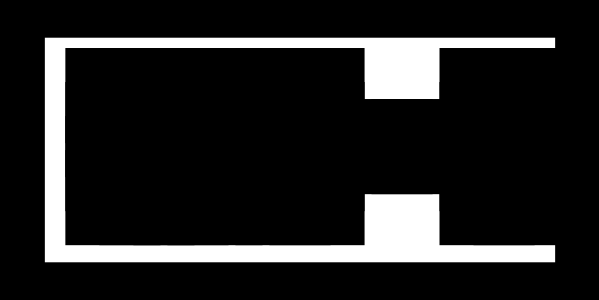

In [15]:
X = torch.rand((4, 4))    # (B, 4)
W = torch.rand((2, 4))    # (2, 4)
b = torch.rand(2) * -1    # (1, 2)
h = X @ W.T + b # (B, 2)

draw(X, W.T, b, h)  

- General rule: right align, add 1s, broadcast with paired dimensions.

### Tensor Operations
- Arithmetic operations: +, -, /, etc. With tensors, or primitives (element-wise).
- '\*' (element-wise multiply) vs. '@' (matrix multiply)
- `torch.stack`, `torch.cat`

In [18]:
d1 = torch.arange(4)[:, None]
d2 = -1 * torch.arange(4)[:, None]
d3 = torch.cat([ d1, d2 ], dim=-1)
d3.shape

torch.Size([4, 2])

- Conversion back to primitives: `numpy()` (numpy array), `tolist()` (python list)

In [20]:
type(pt_data.tolist())

list

### Tensor Operations
- Tensor operations significantly benefit from accelerators: GPUs, etc.
- Device placement: controls tensor memory storage and computation device.
- Default: `cpu`. Migration: `.<device>()`, `.to()`

In [24]:
torch.cuda.is_available()

True

In [25]:
pt_data = torch.rand((2, 3))
pt_data = pt_data.to('cuda')
pt_data.device

device(type='cuda', index=0)

#### Acceleration Advantage

In [26]:
torch.manual_seed(20240130)

pt_data1     = torch.rand(12, 4096, 768)
pt_data1_acc = pt_data1.to('cuda')
np_data1     = pt_data1.numpy()

pt_data2     = torch.rand(12, 768, 4096)
pt_data2_acc = pt_data2.to('cuda')
np_data2     = pt_data2.numpy()

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

#### Acceleration Advantage

In [27]:
%%timeit -r 4
np_data2 @ np_data1

39.9 ms ± 3.58 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)


In [28]:
%%timeit -r 4
pt_data2 @ pt_data1

17.1 ms ± 142 μs per loop (mean ± std. dev. of 4 runs, 100 loops each)


In [29]:
%%timeit -r 4
pt_data2_acc @ pt_data1_acc

3.39 ms ± 410 μs per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


### Utility Functions
- `where`, `view`, `reshape` and `contiguous`

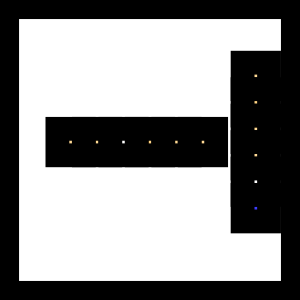

In [36]:
data = torch.randn((1, 6))
data = torch.where(data > 0, data, 0)
data2 = data.view((2, 3)).transpose(1, 0).reshape((6, 1))
data2[-1, 0] = -6
draw(data, data2)

- `transpose` and `permute`

In [38]:
pt_data = torch.rand((2, 3, 5))
new_pt_data = pt_data.permute((2, 0, 1))
new_pt_data.shape

torch.Size([5, 2, 3])

- `gather` and `take`

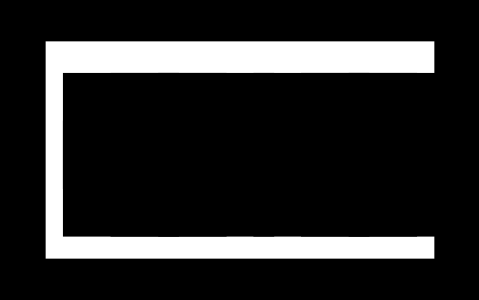

In [41]:
# torch.manual_seed(20250201)
# data = torch.randn((2, 3)) * 10
# index = torch.tensor([ [ 1, 2 ], [ 0, 2 ] ])
# new_data = torch.gather(data, dim=0, index=data.argsort(dim=0))
# draw(data, new_data)

a = torch.rand((5, 32, 32, 3))
a = a[-1, :, :, 1, None ]



- `einops`: Swiss army-knife for many tensor operations. Preserves semantics.

```python
# diagonal: data.diag()
torch.einsum("ii->i", data)

# transpose: data.T
torch.einsum("ij -> ji", data)

# batch matrix multiplication: torch.bmm(batch_data1, batch_data2)
torch.einsum("bik, bkj -> bij", batch_data1, batch_data2)
```

- `einops`: Swiss army-knife for many tensor operations. Preserves semantics.

```python
# axis 0 sum: data.sum(dim=0)
torch.einsum("ij -> j", data)

# all sum: data.sum()
torch.einsum("ij -> ", data)

# reshape/view: x.view(x.shape[0], -1)
einops.rearrange(x, 'b c h w -> b (c h w)')
```

- Additional einops operations (reduction, rearrange, etc.) available in `einops` package: https://einops.rocks

### Automatic Differentiation with `torch.autograd`

- `torch.autograd` prepares computation graphs on the fly for backward passes.
- Seamlessly integrates with tensors: just set `requires_grad=True`!

In [42]:
a = torch.tensor([ [1, 2.] ], requires_grad=True)
b = torch.tensor([ [3, 4.] ])
b.requires_grad = True

d = a ** 2
c = (a + b).T
e = d @ c
e = torch.where(e > 0, e, 0)

e

tensor([[28.]], grad_fn=<WhereBackward0>)

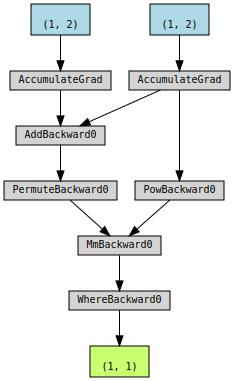

In [43]:
torchviz.make_dot(e)

#### Autograd Essentials: `detach()` and `no_grad()`

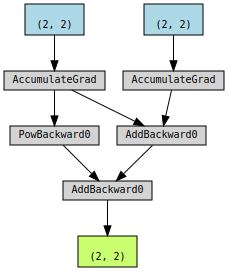

In [44]:
a = torch.rand((2, 2), requires_grad=True)
b = torch.rand((2, 2), requires_grad=True)

c = a + b
d = a ** 2
e = c + d
torchviz.make_dot(e)

- `detach()`: detaches a tensor from the computation graph.

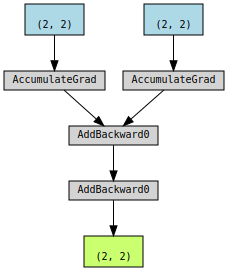

In [45]:
c = a + b
d = (a ** 2).detach()
e = c + d
torchviz.make_dot(e)

- `no_grad()`: prevents book-keeping for the computation graph. Useful for faster inference during evaluations.

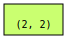

In [47]:
with torch.no_grad():
    c = a + b
    d = a ** 2
    e = c + d
torchviz.make_dot(e)

- `inference_mode()`: similar to `no_grad()`, but disables autograd tracking altogether. Recommended for model inference during evaluations.

In [48]:
with torch.inference_mode():
    c = a + b
    d = a ** 2
    e = c + d
e.requires_grad = True

RuntimeError: Setting requires_grad=True on inference tensor outside InferenceMode is not allowed.

### Putting it Together: Deep-Learning with Pytorch

- Scenario: 2-Layer MLP with ReLU activation for learning floating-point subtraction
- Data: $X \in \mathbb{R}^{2\times m}, Y_{true} \in \mathbb{R}^{1\times m}$
- Forward Pass:

$$W_1 \in \mathbb{R}^{2\times2}, W_2 \in \mathbb{R}^{1\times2}, b_1 \in \mathbb{R}^{2\times1}, b_2 \in \mathbb{R}$$

  1. $$ H_1 = \text{ReLU}(W_1 X + b) $$
  2. $$ Y_{predicted} = W_2 H_1 + b_2 $$

- Loss Function: MSE
  $$L(W_1, W_2, b_1, b_2) = \frac{1}{2m}\sum_{i=1}^{m}(y_{predicted}^{(i)} - y_{true}^{(i)})^2$$
  $$\implies L(W_1, W_2, b_1, b_2) = \frac{1}{2m} (Y_{predicted} - Y_{true})^\top(Y_{predicted} - Y_{true})$$

- Backward Pass:
  - $$\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial Y_{p}}\frac{\partial Y_{p}}{\partial W_2} = \frac{1}{m} (Y_p - Y_t) H_1^\top $$
  - $$\frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial Y_{p}}\frac{\partial Y_{p}}{\partial b_2} = \frac{1}{m} \sum_{i=1}^{m} (y_p^{(i)} - y_t^{(i)}) $$
  - $$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial Y_{p}}\frac{\partial Y_{p}}{\partial H_1}\frac{\partial H_1}{\partial W_1} = \frac{1}{m} ( W_2^\top (Y_p - Y_t)  \cdot [H_1 > 0] ) X^\top $$
  - $$\frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial Y_{p}}\frac{\partial Y_{p}}{\partial H_1}\frac{\partial H_1}{\partial b_1} = \frac{1}{m} \sum_{i=1}^{m} ( W_2^\top (Y_p - Y_t)  \cdot [H_1 > 0] ) ^ {(i)}$$

In [49]:
def mlp_init(x_dim, y_dim):
    prng = numpy.random.default_rng(seed=20240130)
    W1 = prng.uniform(-1, 1, size=(2, x_dim))
    W2 = prng.uniform(-1, 1, size=(y_dim, 2))
    b1 = numpy.zeros((2, 1))
    b2 = numpy.zeros((y_dim, 1))

    return W1, W2, b1, b2

def mlp_forward(x, W1, W2, b1, b2):
    if len(x.shape) < 2: x = x[:, numpy.newaxis].T
    h1 = (W1 @ x.T) + b1
    h1 = numpy.maximum(h1, 0)
    return h1, ((W2 @ h1) + b2).T

In [50]:
def mlp_backward(x, y, h, y_pred, W1, W2, b1, b2, lr=0.01):
    if len(x.shape) < 2: x = x[:, numpy.newaxis].T
    if len(y.shape) < 2: y = y[:, numpy.newaxis]
    if len(y_pred.shape) < 2: y_pred = y_pred[:, numpy.newaxis]

    # compute gradients as per calculations
    num_pts = x.shape[0]
    grad_y_pred = (y_pred - y).T / num_pts

    grad_h = W2.T @ grad_y_pred
    grad_h[h <= 0] = 0

    grad_W1 = grad_h @ x
    grad_W2 = grad_y_pred @ h.T
    grad_b1 = numpy.sum(grad_h, axis=1, keepdims=True) 
    grad_b2 = numpy.sum(grad_y_pred, axis=1, keepdims=True)

    # update weights
    W1 = W1 - lr * grad_W1
    W2 = W2 - lr * grad_W2
    b1 = b1 - lr * grad_b1
    b2 = b2 - lr * grad_b2

    return W1, W2, b1, b2

In [51]:
prng = numpy.random.default_rng(seed=20240130)
X = prng.random(size=(1000, 2))
Y = (X[:, 0] - X[:, 1]).reshape(-1, 1)

losses = []
W1, W2, b1, b2 = mlp_init(X.shape[-1], Y.shape[-1])

num_epochs, batch_size = 100, 10
num_batches = len(X) // batch_size

with tqdm.tqdm(total = num_epochs * num_batches) as pbar:
    for epoch in range(num_epochs):
        pbar.set_description(f"Epoch #{epoch+1}")

        for i in range(num_batches):
            start = i * batch_size
            x_batch = X[start:start+batch_size]
            y_batch = Y[start:start+batch_size]

            h, y_pred = mlp_forward(x_batch, W1, W2, b1, b2)
            loss = 0.5 * numpy.mean((y_pred - y_batch) ** 2)
            losses.append(float(loss.squeeze()))
            W1, W2, b1, b2 = mlp_backward(x_batch, y_batch, h, y_pred, W1, W2, b1, b2)

            pbar.update(1)
            pbar.set_postfix(dict(loss=loss))

  0%|          | 0/10000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

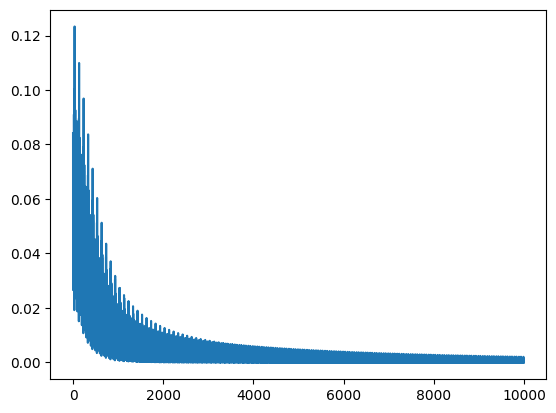

In [52]:
pyplot.plot(losses)

In [53]:
mlp_forward(numpy.array([ 0.69, 0.42 ]), W1, W2, b1, b2)[-1].squeeze()

array(0.27104206)

#### Simplification with PyTorch basic units

In [ ]:
def mlp_init_pt(x_dim, y_dim):
    torch.manual_seed(20240130)
    prng = numpy.random.default_rng(seed=20240130)
    W1 = prng.uniform(-1, 1, size=(2, x_dim))
    W2 = prng.uniform(-1, 1, size=(y_dim, 2))
    W1 = torch.tensor(W1, requires_grad=True)
    W2 = torch.tensor(W2, requires_grad=True)
    b1 = torch.zeros((2, 1), requires_grad=True)
    b2 = torch.zeros((y_dim, 1), requires_grad=True)
    return W1, W2, b1, b2

def mlp_forward_pt(x, W1, W2, b1, b2):
    if len(x.shape) < 2: x = x[:, None].T
    h1 = (W1 @ x.T) + b1
    h1 = torch.where(h1 > 0, h1, 0)
    return h1, ((W2 @ h1) + b2).T

In [54]:
def mlp_backward_pt(loss, W1, W2, b1, b2, lr=0.01):
    loss.backward()

    # update weights
    W1.data = W1 - lr * W1.grad
    W2.data = W2 - lr * W2.grad
    b1.data = b1 - lr * b1.grad
    b2.data = b2 - lr * b2.grad

    W1.grad = W2.grad = b1.grad = b2.grad = None

    return W1, W2, b1, b2

In [ ]:
X, Y = torch.as_tensor(X), torch.as_tensor(Y)

losses = []
W1, W2, b1, b2 = mlp_init_pt(X.shape[-1], Y.shape[-1])

num_epochs, batch_size = 100, 10
num_batches = len(X) // batch_size

with tqdm.tqdm(total = num_epochs * num_batches) as pbar:
    for epoch in range(num_epochs):
        pbar.set_description(f"Epoch #{epoch+1}")

        for i in range(num_batches):
            start = i * batch_size
            x_batch = X[start:start+batch_size]
            y_batch = Y[start:start+batch_size]

            h, y_pred = mlp_forward_pt(x_batch, W1, W2, b1, b2)
            loss = 0.5 * torch.mean((y_pred - y_batch) ** 2)

            losses.append(loss.squeeze().item())
            W1, W2, b1, b2 = mlp_backward_pt(loss, W1, W2, b1, b2)

            pbar.update(1)
            pbar.set_postfix(dict(loss=loss.item()))

In [ ]:
pyplot.plot(losses)

In [ ]:
with torch.no_grad():
    output = mlp_forward_pt(torch.tensor([ 0.69, 0.42 ], dtype=torch.float64), W1, W2, b1, b2)[-1].squeeze()
output

### Scaling Deep Learning with PyTorch Modules

- `torch.nn`: Neural network utilties, activation functions, losses, etc.
- `torch.optim`: Optimizers for deep learning, utilizing autograd.
- `torch.utils.data`: Data processing utilities.

#### `torch.nn`

- Provides neural network components: losses, layer modules, activations, etc.

- Layer components: `nn.Linear`, `nn.Embedding`, `nn.Conv2d`, `nn.LSTM`, etc.
    - Regularization and Stability: `nn.Dropout`, `nn.BatchNorm1d`, etc.
    - Layer compositions: `nn.Module`, `nn.Sequential`, `nn.ModuleList`, `nn.ModuleDict`

```python
model = torch.nn.Sequential(
    torch.nn.Linear(X.shape[-1], 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, Y.shape[-1])
)
```

- Activations: `nn.ReLU` / `nn.functional.relu`, etc.
- Losses: `nn.CrossEntropyLoss` / `nn.functional.cross_entropy`, etc.

- Using `nn.Module` for fine-grained control:

In [55]:
class MLP(torch.nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()

        self.layer_1 = torch.nn.Linear(x_dim, 2)
        self.layer_1_act = torch.nn.ReLU()
        self.layer_2 = torch.nn.Linear(2, y_dim)

    def forward(self, inputs):
        hidden = self.layer_1_act(self.layer_1(inputs))
        return self.layer_2(hidden)

In [56]:
model = MLP(2, 1)

for name, param in model.named_parameters():
    print(name, param.requires_grad)

layer_1.weight True
layer_1.bias True
layer_2.weight True
layer_2.bias True


#### `torch.utils.data`

- Provides data processing utilites, such as a dataloader to process batches.

In [64]:
dataset = torch.utils.data.TensorDataset(torch.rand((40, 2)), torch.rand((40, 1)))
dataset[2] # x and y clubbed as intended.

(tensor([0.4854, 0.2087]), tensor([0.6260]))

In [65]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
for x_batch, y_batch in dataloader:
    print(x_batch.shape, y_batch.shape)

torch.Size([10, 2]) torch.Size([10, 1])
torch.Size([10, 2]) torch.Size([10, 1])
torch.Size([10, 2]) torch.Size([10, 1])
torch.Size([10, 2]) torch.Size([10, 1])


### `torch.optim`

- Provides optimizers and schedulers for scalable deep learning.
- Common: `torch.optim.Adam`, `torch.optim.SGD`, etc.
    

In [66]:
model = MLP(X.shape[-1], Y.shape[-1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Sync gradients (optim specific W.data = W.data - eta * W.grad)
optimizer.step()

In [ ]:
# Clear synced gradients from parameter tensors (optim specific W.grad = None)
optimizer.zero_grad()

#### Putting it together

In [ ]:
def mlp_init_true_pt(x_dim, y_dim):
    model = MLP(x_dim, y_dim)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return model, optimizer

def mlp_forward_true_pt(X, model):
    return model(X)

def mlp_backward_true_pt(loss, model, optimizer):
    loss.backward()
    optimizer.step()
    model.zero_grad()

In [ ]:
losses = []
model, optimizer = mlp_init_true_pt(X.shape[-1], Y.shape[-1])

num_epochs, batch_size = 100, 10

dataset    = torch.utils.data.TensorDataset(
    torch.as_tensor(X, dtype=torch.float32),
    torch.as_tensor(Y, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

with tqdm.tqdm(total = num_epochs * len(dataloader)) as pbar:
    for epoch in range(num_epochs):
        pbar.set_description(f"Epoch #{epoch+1}")

        for x_batch, y_batch in dataloader:
            y_pred = mlp_forward_true_pt(x_batch, model)
            loss = torch.nn.functional.mse_loss(y_pred, y_batch)
            mlp_backward_true_pt(loss, model, optimizer)

            pbar.update(1)
            pbar.set_postfix(dict(loss=loss.item()))
            losses.append(loss.cpu().item())

In [ ]:
pyplot.plot(losses)

In [ ]:
with torch.no_grad():
    output = model(torch.tensor([[ 0.69, 0.42 ]]))
output

#### Inference Caveats

- Some layers (`nn.Dropout`, `nn.LayerNorm`, etc.) behave differently as per inference mode: training or evaluation.
- Set behavior jointly for all such components: `train()` / `eval()`

In [ ]:
# model should be used only for training
model.train()

# model should be used for inference
model.eval() # or model.train(False)

#### Saving and Loading Trained Models

- Saving: `torch.save` (with or without class information)
- Loading: `torch.load`

In [ ]:
# save and load with existing model object
torch.save(model.state_dict(), "model_dict.pt")
model.load_state_dict(torch.load("model_dict.pt"))

In [ ]:
# save and load without object
torch.save(model, "model.pt")
model = torch.load("model.pt")

### References

- [Deep Learning with PyTorch: a 60 Minute Blitz by pytorch.org](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [Tutorials about different things PyTorch](https://pytorch.org/tutorials)
  - [Introduction to PyTorch - YouTube Series](https://pytorch.org/tutorials/beginner/introyt.html)
- PyTorch Repository on [GitHub](https://github.com/pytorch/pytorch)
- [PyTorch Cheatsheet for Quick References](https://pytorch.org/tutorials/beginner/ptcheat.html)
- [Jupyter Slides - HKUST](https://digitalhumanities.hkust.edu.hk/tutorials/turn-your-jupyter-notebook-into-interactive-presentation-slides-using-anaconda/)

- [RISE for jupyter](https://rise.readthedocs.io/)
- [Pytorch Tensor Puzzles by Alexander Rush](https://github.com/srush/Tensor-Puzzles)